In [465]:
import torch 
import numpy as np
import pickle
from torch import nn, optim
from torch.nn import functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tqdm
import data_utils
from random import seed
import utils

In [466]:
np.random.seed(12)
seed(12)
torch.manual_seed(12)

In [467]:
# dataset path
data_path = "./data/var_u.mat" # Orig IB data

# Run on GPU if possible
try_gpu = False
if try_gpu:
    cuda = torch.cuda.is_available() 
    device = torch.device("cuda" if cuda else "cpu")
else:
    device = torch.device("cpu")
print("Using "+ str(device))

Using cpu


In [468]:
random_split = True
if random_split:
    X_train, X_test, y_train, y_test = data_utils.load_data(data_path)
else:
    trn, tst = utils.get_ib_data()
    X_train, y_train, c_train = utils.tensor_casting(trn)
    X_test, y_test, c_test = utils.tensor_casting(tst)

In [469]:
### lr=0.0004 for full batch with Adam. 
# batch_size 256 lr = 0.01 adam lr_scheduler 300 patience, default params else.

In [470]:
config = {
    "loss_function" : nn.CrossEntropyLoss(),
    "batch_size" : 256,
    "epochs" : 100,
}

layer_sizes = [12,10,7,5,4,3,2]

In [471]:
# Prepare data for pytorch
if config["batch_size"] != "full":
    train_loader = data_utils.create_dataloader(X_train, y_train, config["batch_size"])
    test_loader = data_utils.create_dataloader(X_test, y_test, config["batch_size"])
else:
    train_loader = data_utils.create_dataloader(X_train, y_train, len(X_train))
    test_loader = data_utils.create_dataloader(X_test, y_test, len(X_test))

# Activitiy loaders
full_X, full_y = np.concatenate((X_train, X_test)), np.concatenate((y_train, y_test))
act_full_loader = data_utils.create_dataloader(full_X, full_y, len(full_X))
act_train_loader = data_utils.create_dataloader(X_train, y_train, len(X_train))
act_test_loader = data_utils.create_dataloader(X_test, y_test, len(X_test))
act_loaders = [act_full_loader]

In [472]:
# What do collect during training.
# Gradients of weights for all layers: something like ib_model.h3.weight.grad
# Weights for each layer: ib_model.h3.weight
# Activity: Save it in the forward pass and keep track of batch things.

# Compute L2 norm of weights
# Mean of gradients
# Std of gradients 
# Activity <- needed for MI 

In [473]:
class FNN(nn.Module):
    def __init__(self, layer_sizes, activation="tanh", seed=0):
        super(FNN, self).__init__()
        torch.manual_seed(seed)
        self.linears = nn.ModuleList()
        self.activation = activation
        self.num_layers = len(layer_sizes)
        self.inp_size = layer_sizes[0]
        
        h_in = self.inp_size
        for h_out in layer_sizes[1:]:
            self.linears.append(nn.Linear(h_in, h_out))
            h_in = h_out
    
        
    def forward(self, x):
        activations = [] #TODO: Could be nicer
        for idx in range(self.num_layers-2):
            x = self.linears[idx](x)
            if self.activation == "tanh":
                x = torch.tanh(x)
            elif self.activation == "relu":
                x = F.relu(x)
            else:
                raise("Activation Function not supported. Please choose \"tanh\" or \"relu\"")
            if not self.training: #Internal flag in model
                activations.append(x)
        x = self.linears[-1](x)
        if not self.training: #Internal flag in model
            activations.append(F.softmax(x, dim=-1))
            
        return x, F.softmax(x, dim=-1), activations

In [474]:
ib_model = FNN(layer_sizes, activation="relu").to(device)

In [475]:
#512, lr 0.003

In [476]:
optimizer = torch.optim.SGD(ib_model.parameters(), lr=0.003, momentum=0.9z)

SyntaxError: invalid syntax (<ipython-input-476-3f2ba23f9858>, line 1)

In [477]:
optimizer = optim.Adam(ib_model.parameters(), lr = 0.0004)

In [478]:
from distributions import truncated_normal_

In [479]:
import torch 
import numpy as np
import pickle
from torch import nn, optim
from torch.nn import functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from distributions import truncated_normal_
import tqdm
import data_utils
from random import seed
import utils

class Trainer:
    def __init__(self, cfg, model, optimizer, device):
        self.opt = optimizer
        self.device = device
        self.loss_function = cfg["loss_function"]
        self.epochs = cfg["epochs"]
        self.model = model
        self.hidden_activations = [] # index 1: epoch num, index2 : layer_num
        self.hidden_activations_test = []
        self.hidden_activations_train = []
        self.val_loss = []
        self.train_loss = []
        self.full_loss = []
        self.error_train = []
        self.error_test = []
        #self.weights = dict() #  Not currently in use, but if plot of grad of weights are needed we need this
        #self.ws_grads = dict() # Not currently in use, but if plot of grad of weights are needed we need this
        
    def _init_weights(self, layer):
        """
        Initialize the weights and bias for each linear layer in the model.
        """
        if type(layer) == nn.Linear:
            # Truncated normal is only available in their unstable nightly version
            #nn.init.trunc_normal_(layer.weight, mean=0, std=1/np.sqrt(layer.weight.shape[0]))
            truncated_normal_(layer.weight)
            if layer.bias != None: 
                layer.bias.data.fill_(0.00)

        
    def _get_epoch_activity(self, loader, val=False):
        """
        After each epoch save the activation of each hidden layer
        """
        self.model.eval()
        v_loss = 0
        acc = 0
        with torch.no_grad(): # Speeds up very little by turning autograd engine off.
            for data, label in loader:
                data, label= data.to(self.device), label.long().to(self.device)
                yhat, yhat_softmax, activations = self.model(data)
                v_loss += self.loss_function(yhat, label).item()
                acc += self._get_number_correct(yhat_softmax, label).item()
                
        v_loss = v_loss / len(loader.dataset)
        if val:
            acc = acc / float(len(loader.dataset))
            self.error_test.append(1-acc)
            #print('Validation loss: {:.7f},  Validation Acc. {:.4f}'.format(v_loss, acc))
            self.val_loss.append(v_loss)
        else:
           #print('Full loss: {:.7f}'.format(v_loss))
            self.full_loss.append(v_loss)
        return v_loss, list(map(lambda x:x.cpu().numpy(), activations))
    
    
    def _loop_act_loaders(self, loaders):
        """
        If we want to save the activity after each epoch for more that one dataset.
        I.e some papers save activity for both train, test and test+train. 
        Note that the order is important here. TODO: change loaders to be a dict.
        """
        counter = 0
        for loader in loaders:
            v_loss, act = self._get_epoch_activity(loader)
            if counter == 0:
                self.hidden_activations.append(act)
            elif counter == 1:
                self.hidden_activations_train.append(act)
            elif counter == 2:
                self.hidden_activations_test.append(act)
            counter += 1
            
    
    def _get_number_correct(self, output, target):
        """
        Returns number of correct predictions from the softmax output. 
        Requires target to be a flat vector i.e not one-hot encoded.
        """
        n_corr = (target == output.argmax(dim=1)).sum()
        return n_corr 
    
    
    def train(self, train_loader, test_loader, act_loaders):
        MI_tracker = 1
        self.model.apply(self._init_weights) #Init kernel weights
        #scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.opt, 'min', verbose=True, patience=300)
        for epoch in tqdm.tqdm(range(1, self.epochs+1)):
            ### START MAIN TRAIN LOOP ###
            self.model.train()
            train_loss = 0
            acc_train = 0
            for train_data, label in train_loader: 
                train_data, label  = train_data.to(self.device), label.long().to(self.device)
                yhat, yhat_softmax, _ = self.model(train_data)
                loss = self.loss_function(yhat, label)
                acc_train += self._get_number_correct(yhat_softmax, label).item()
                self.opt.zero_grad()
                loss.backward()
                train_loss += loss.item()
                self.opt.step()
            self.error_train.append(1-acc_train)
            train_loss = train_loss / len(train_loader.dataset)
            self.train_loss.append(train_loss)
            #print('Epoch: {} Train loss: {:.7f},  Train Acc. {:.4f}'.format(epoch, train_loss, acc_train / float(len(train_loader.dataset))))
            ### STOP MAIN TRAIN LOOP ###
        
            ### RUN ON VALIDATION DATA ###
            val_loss = self._get_epoch_activity(test_loader, val=True)[0]
            #scheduler.step(val_loss) #Reduce LR on plateau.
            
            ### SAVE ACTIVATION ON FULL DATA ###
            self._loop_act_loaders(act_loaders)
            #print("-"*50)

In [480]:
tr = Trainer(config, ib_model, optimizer, device)
tr.train(train_loader, test_loader, act_loaders)

100%|██████████| 100/100 [00:09<00:00, 10.88it/s]


In [481]:
act_loaders[0]

In [493]:
class MI:
    def __init__(self, activity, data_loader, act="tanh", num_of_bins = 30, binsize=0.07):
        self.activity = activity
        self.num_of_bins = num_of_bins
        self.binsize = binsize
        self.act = act
        
        if act == "tanh":
            self.min_val = -1
            self.max_val = 1
        else:
            self.min_val = 0
            #self.max_val = network_utils.get_max_value(activity)
        
        self.X = data_loader.dataset.tensors[0].numpy()
        self.y_flat = data_loader.dataset.tensors[1].numpy()
        
        classes = len(np.unique(self.y_flat))
        self.y_onehot = np.eye(classes)[self.y_flat.astype("int")]
        nb_classes = self.y_onehot[0]
        self.y_idx_label = {x : None for x in nb_classes}
        for i in self.y_idx_label:
            self.y_idx_label[i] = i == self.y_flat
            
    
    def entropy_fixed_binsize(self, activations):
        binned = np.floor(activations / self.binsize).astype('int')
        _, unique_layers = np.unique(binned, axis=0, return_counts=True)
        prob_hidden_layers = unique_layers / sum(unique_layers)
        return -np.sum(prob_hidden_layers * np.log2(prob_hidden_layers))
    
    
    def entropy_fixed_num_bins(self, activations):
        bins = np.linspace(self.min_val, self.max_val, self.num_of_bins)
        binned = np.digitize(activations, bins)
        _, unique_layers = np.unique(binned, axis=0, return_counts=True)
        prob_hidden_layers = unique_layers / sum(unique_layers)
        return -np.sum(prob_hidden_layers * np.log2(prob_hidden_layers))


    def entropy_fixed_adapt_binsize(self, bins, activations):
        print(bins.shape)
        binned = np.digitize(activations, bins)
        _, unique_layers = np.unique(binned, axis=0, return_counts=True)
        prob_hidden_layers = unique_layers / sum(unique_layers)
        return -np.sum(prob_hidden_layers * np.log2(prob_hidden_layers))


    
    def mi_binning_fixed(self, labelixs, activations_layer):
        entropy_layer = self.entropy_fixed_num_bins(activations_layer)
        entropy_layer_output = 0
        for label, ixs in labelixs.items():
         #   print(ixs.mean())
            h = self.entropy_fixed_num_bins(activations_layer[ixs])
            entropy_layer_output += ixs.mean() * h
        return entropy_layer, (entropy_layer - entropy_layer_output)


    def mi_binning_adapt(self, labelixs, activations_layer, bins):
        entropy_layer = self.entropy_fixed_adapt_binsize(bins, activations_layer)
        entropy_layer_output = 0
        for label, ixs in labelixs.items():
         #   print(ixs.mean())
            h = self.entropy_fixed_adapt_binsize(bins, activations_layer[ixs])
            entropy_layer_output += ixs.mean() * h
        return entropy_layer, (entropy_layer - entropy_layer_output)

    
    
    def get_MI(self, method="fixed"):
        all_MI_XH = [] # Contains I(X;H) and stores it as (epoch_num, layer_num)
        all_MI_YH = [] # Contains I(Y;H) and stores it as (epoch_num, layer_num
        if method == "fixed":
            for epoch in tqdm.tqdm(self.activity):
                temp_MI_XH = []
                temp_MI_YH = []
                for layer_num in range(len(epoch)):
                    MI_XH, MI_YH = self.mi_binning_fixed(self.y_idx_label,
                                                       epoch[layer_num])
                    temp_MI_XH.append(MI_XH)
                    temp_MI_YH.append(MI_YH)
                all_MI_XH.append(temp_MI_XH)
                all_MI_YH.append(temp_MI_YH)

        elif method == "adaptive":
            max_vals, adapt_bins = get_bins_layers(self.activity, self.num_of_bins, act=self.act)
            print(adapt_bins[0][0])
            for idx, epoch in tqdm.tqdm(enumerate(self.activity)):
                temp_MI_XH = []
                temp_MI_YH = []
                for layer_num in range(len(epoch)):
                    MI_XH, MI_YH = self.mi_binning_adapt(self.y_idx_label,
                                                       epoch[layer_num],
                                                       adapt_bins[idx][layer_num])
                    print(adapt_bins[idx][layer_num])
                    print("*----*"*20)
                    temp_MI_XH.append(MI_XH)
                    temp_MI_YH.append(MI_YH)
                all_MI_XH.append(temp_MI_XH)
                all_MI_YH.append(temp_MI_YH)

        else:
            raise("Method not supported. Pick fixed or adaptive")
        return all_MI_XH, all_MI_YH

def get_max_value(activity):
    """
    Activity is an array for the activity 
    for each layer 
    """
    max_val = 0
    for i in activity:
        for j in i:
            mm = j.max()
            if mm > max_val:
                max_val = mm
    return max_val

def get_max_val_all_layers(activations):
    max_vals = []
    for epoch in activations:
        max_epoch = []
        for layer in epoch:
            max_epoch.append(layer.max())
        max_vals.append(max_epoch)
    return max_vals




def get_bins_layers(activations, num_bins, act="relu"):

    max_vals = get_max_val_all_layers(activations)
    bins = []
    min_val = 0.0
    for epoch in activations:
        epoch_bins=[]
        for layer in epoch:
            layer_bins=[min_val]
            unique_act_vals=np.unique(np.squeeze(layer.reshape(1,-1)))
            sorted_ua = np.sort(np.setdiff1d(unique_act_vals,layer_bins)) # sorted unique activations not in layer_bins
            if sorted_ua.size>0:
                for k in range(num_bins):
                    ind=int(k*(sorted_ua.size/num_bins))
                    layer_bins.append(sorted_ua[ind])
                    #print(ind)
                layer_bins.append(sorted_ua[-1])
            #print(len(layer_bins))
            epoch_bins.append(np.asarray(layer_bins))
        bins.append(epoch_bins)    
    return max_vals, np.array(bins)


In [494]:
mutual_inf = MI(tr.hidden_activations, act_full_loader,act="relu", num_of_bins=100)

In [495]:
mutual_inf.max_val

AttributeError: 'MI' object has no attribute 'max_val'

In [496]:
MI_XH, MI_YH = mutual_inf.get_MI(method="adaptive")

0
232
464
696
928
1161
1393
1625
1857
2090
2322
2554
2786
3019
3251
3483
3715
3948
4180
4412
4644
4877
5109
5341
5573
5806
6038
6270
6502
6734
6967
7199
7431
7663
7896
8128
8360
8592
8825
9057
9289
9521
9754
9986
10218
10450
10683
10915
11147
11379
11612
11844
12076
12308
12540
12773
13005
13237
13469
13702
13934
14166
14398
14631
14863
15095
15327
15560
15792
16024
16256
16489
16721
16953
17185
17418
17650
17882
18114
18346
18579
18811
19043
19275
19508
19740
19972
20204
20437
20669
20901
21133
21366
21598
21830
22062
22295
22527
22759
22991
0
189
379
569
758
948
1138
1327
1517
1707
1896
2086
2276
2465
2655
2845
3034
3224
3414
3603
3793
3983
4172
4362
4552
4742
4931
5121
5311
5500
5690
5880
6069
6259
6449
6638
6828
7018
7207
7397
7587
7776
7966
8156
8345
8535
8725
8914
9104
9294
9484
9673
9863
10053
10242
10432
10622
10811
11001
11191
11380
11570
11760
11949
12139
12329
12518
12708
12898
13087
13277
13467
13656
13846
14036
14226
14415
14605
14795
14984
15174
15364
15553
15743
15933
16

5451
5533
5614
5695
5777
5858
5940
6021
6102
6184
6265
6346
6428
6509
6590
6672
6753
6835
6916
6997
7079
7160
7241
7323
7404
7486
7567
7648
7730
7811
7892
7974
8055
0
217
434
652
869
1087
1304
1521
1739
1956
2174
2391
2608
2826
3043
3261
3478
3695
3913
4130
4348
4565
4783
5000
5217
5435
5652
5870
6087
6304
6522
6739
6957
7174
7391
7609
7826
8044
8261
8478
8696
8913
9131
9348
9566
9783
10000
10218
10435
10653
10870
11087
11305
11522
11740
11957
12174
12392
12609
12827
13044
13262
13479
13696
13914
14131
14349
14566
14783
15001
15218
15436
15653
15870
16088
16305
16523
16740
16957
17175
17392
17610
17827
18045
18262
18479
18697
18914
19132
19349
19566
19784
20001
20219
20436
20653
20871
21088
21306
21523
0
183
367
550
734
917
1101
1284
1468
1652
1835
2019
2202
2386
2569
2753
2937
3120
3304
3487
3671
3854
4038
4222
4405
4589
4772
4956
5139
5323
5507
5690
5874
6057
6241
6424
6608
6792
6975
7159
7342
7526
7709
7893
8077
8260
8444
8627
8811
8994
9178
9362
9545
9729
9912
10096
10279
10463
106

0
203
407
611
815
1019
1222
1426
1630
1834
2038
2242
2445
2649
2853
3057
3261
3465
3668
3872
4076
4280
4484
4688
4891
5095
5299
5503
5707
5911
6114
6318
6522
6726
6930
7134
7337
7541
7745
7949
8153
8357
8560
8764
8968
9172
9376
9580
9783
9987
10191
10395
10599
10802
11006
11210
11414
11618
11822
12025
12229
12433
12637
12841
13045
13248
13452
13656
13860
14064
14268
14471
14675
14879
15083
15287
15491
15694
15898
16102
16306
16510
16714
16917
17121
17325
17529
17733
17937
18140
18344
18548
18752
18956
19160
19363
19567
19771
19975
20179
0
172
344
516
689
861
1033
1205
1378
1550
1722
1894
2067
2239
2411
2583
2756
2928
3100
3272
3445
3617
3789
3961
4134
4306
4478
4650
4823
4995
5167
5339
5512
5684
5856
6028
6201
6373
6545
6717
6890
7062
7234
7406
7579
7751
7923
8095
8268
8440
8612
8784
8957
9129
9301
9473
9646
9818
9990
10162
10335
10507
10679
10851
11024
11196
11368
11540
11713
11885
12057
12229
12402
12574
12746
12918
13091
13263
13435
13607
13780
13952
14124
14296
14469
14641
14813
14

0
202
405
607
810
1012
1215
1417
1620
1822
2025
2227
2430
2632
2835
3037
3240
3442
3645
3847
4050
4252
4455
4657
4860
5063
5265
5468
5670
5873
6075
6278
6480
6683
6885
7088
7290
7493
7695
7898
8100
8303
8505
8708
8910
9113
9315
9518
9720
9923
10126
10328
10531
10733
10936
11138
11341
11543
11746
11948
12151
12353
12556
12758
12961
13163
13366
13568
13771
13973
14176
14378
14581
14783
14986
15189
15391
15594
15796
15999
16201
16404
16606
16809
17011
17214
17416
17619
17821
18024
18226
18429
18631
18834
19036
19239
19441
19644
19846
20049
0
170
340
510
681
851
1021
1191
1362
1532
1702
1873
2043
2213
2383
2554
2724
2894
3065
3235
3405
3575
3746
3916
4086
4257
4427
4597
4767
4938
5108
5278
5448
5619
5789
5959
6130
6300
6470
6640
6811
6981
7151
7322
7492
7662
7832
8003
8173
8343
8514
8684
8854
9024
9195
9365
9535
9705
9876
10046
10216
10387
10557
10727
10897
11068
11238
11408
11579
11749
11919
12089
12260
12430
12600
12771
12941
13111
13281
13452
13622
13792
13962
14133
14303
14473
14644
14

0
188
376
564
753
941
1129
1318
1506
1694
1883
2071
2259
2448
2636
2824
3013
3201
3389
3578
3766
3954
4143
4331
4519
4708
4896
5084
5273
5461
5649
5838
6026
6214
6403
6591
6779
6968
7156
7344
7533
7721
7909
8098
8286
8474
8663
8851
9039
9228
9416
9604
9793
9981
10169
10358
10546
10734
10923
11111
11299
11488
11676
11864
12053
12241
12429
12618
12806
12994
13183
13371
13559
13748
13936
14124
14313
14501
14689
14878
15066
15254
15443
15631
15819
16008
16196
16384
16573
16761
16949
17138
17326
17514
17703
17891
18079
18268
18456
18644
0
195
391
587
783
978
1174
1370
1566
1762
1957
2153
2349
2545
2741
2936
3132
3328
3524
3720
3915
4111
4307
4503
4698
4894
5090
5286
5482
5677
5873
6069
6265
6461
6656
6852
7048
7244
7440
7635
7831
8027
8223
8418
8614
8810
9006
9202
9397
9593
9789
9985
10181
10376
10572
10768
10964
11160
11355
11551
11747
11943
12138
12334
12530
12726
12922
13117
13313
13509
13705
13901
14096
14292
14488
14684
14880
15075
15271
15467
15663
15858
16054
16250
16446
16642
16837


0
197
394
592
789
986
1184
1381
1578
1776
1973
2170
2368
2565
2763
2960
3157
3355
3552
3749
3947
4144
4341
4539
4736
4934
5131
5328
5526
5723
5920
6118
6315
6512
6710
6907
7104
7302
7499
7697
7894
8091
8289
8486
8683
8881
9078
9275
9473
9670
9868
10065
10262
10460
10657
10854
11052
11249
11446
11644
11841
12038
12236
12433
12631
12828
13025
13223
13420
13617
13815
14012
14209
14407
14604
14802
14999
15196
15394
15591
15788
15986
16183
16380
16578
16775
16972
17170
17367
17565
17762
17959
18157
18354
18551
18749
18946
19143
19341
19538
0
82
164
247
329
412
494
576
659
741
824
906
988
1071
1153
1236
1318
1400
1483
1565
1648
1730
1812
1895
1977
2060
2142
2224
2307
2389
2472
2554
2636
2719
2801
2884
2966
3048
3131
3213
3296
3378
3460
3543
3625
3708
3790
3872
3955
4037
4120
4202
4284
4367
4449
4532
4614
4696
4779
4861
4944
5026
5108
5191
5273
5356
5438
5520
5603
5685
5768
5850
5932
6015
6097
6180
6262
6344
6427
6509
6592
6674
6756
6839
6921
7004
7086
7168
7251
7333
7416
7498
7580
7663
7745


0
197
395
592
790
987
1185
1382
1580
1777
1975
2172
2370
2568
2765
2963
3160
3358
3555
3753
3950
4148
4345
4543
4740
4938
5136
5333
5531
5728
5926
6123
6321
6518
6716
6913
7111
7308
7506
7704
7901
8099
8296
8494
8691
8889
9086
9284
9481
9679
9877
10074
10272
10469
10667
10864
11062
11259
11457
11654
11852
12049
12247
12445
12642
12840
13037
13235
13432
13630
13827
14025
14222
14420
14617
14815
15013
15210
15408
15605
15803
16000
16198
16395
16593
16790
16988
17185
17383
17581
17778
17976
18173
18371
18568
18766
18963
19161
19358
19556
0
83
167
251
335
419
503
587
671
755
839
923
1007
1090
1174
1258
1342
1426
1510
1594
1678
1762
1846
1930
2014
2098
2181
2265
2349
2433
2517
2601
2685
2769
2853
2937
3021
3105
3188
3272
3356
3440
3524
3608
3692
3776
3860
3944
4028
4112
4196
4279
4363
4447
4531
4615
4699
4783
4867
4951
5035
5119
5203
5286
5370
5454
5538
5622
5706
5790
5874
5958
6042
6126
6210
6294
6377
6461
6545
6629
6713
6797
6881
6965
7049
7133
7217
7301
7384
7468
7552
7636
7720
7804
7888

0
197
394
591
788
985
1182
1379
1576
1773
1971
2168
2365
2562
2759
2956
3153
3350
3547
3744
3942
4139
4336
4533
4730
4927
5124
5321
5518
5715
5913
6110
6307
6504
6701
6898
7095
7292
7489
7686
7884
8081
8278
8475
8672
8869
9066
9263
9460
9657
9855
10052
10249
10446
10643
10840
11037
11234
11431
11628
11826
12023
12220
12417
12614
12811
13008
13205
13402
13599
13797
13994
14191
14388
14585
14782
14979
15176
15373
15570
15768
15965
16162
16359
16556
16753
16950
17147
17344
17541
17739
17936
18133
18330
18527
18724
18921
19118
19315
19512
0
91
182
274
365
457
548
640
731
823
914
1006
1097
1189
1280
1372
1463
1555
1646
1738
1829
1921
2012
2104
2195
2287
2378
2469
2561
2652
2744
2835
2927
3018
3110
3201
3293
3384
3476
3567
3659
3750
3842
3933
4025
4116
4208
4299
4391
4482
4574
4665
4756
4848
4939
5031
5122
5214
5305
5397
5488
5580
5671
5763
5854
5946
6037
6129
6220
6312
6403
6495
6586
6678
6769
6861
6952
7043
7135
7226
7318
7409
7501
7592
7684
7775
7867
7958
8050
8141
8233
8324
8416
8507
859

12400
12597
12794
12991
13188
13385
13581
13778
13975
14172
14369
14566
14763
14959
15156
15353
15550
15747
15944
16140
16337
16534
16731
16928
17125
17321
17518
17715
17912
18109
18306
18502
18699
18896
19093
19290
19487
0
106
213
320
427
534
640
747
854
961
1068
1175
1281
1388
1495
1602
1709
1815
1922
2029
2136
2243
2350
2456
2563
2670
2777
2884
2990
3097
3204
3311
3418
3525
3631
3738
3845
3952
4059
4165
4272
4379
4486
4593
4700
4806
4913
5020
5127
5234
5341
5447
5554
5661
5768
5875
5981
6088
6195
6302
6409
6516
6622
6729
6836
6943
7050
7156
7263
7370
7477
7584
7691
7797
7904
8011
8118
8225
8331
8438
8545
8652
8759
8866
8972
9079
9186
9293
9400
9506
9613
9720
9827
9934
10041
10147
10254
10361
10468
10575
0
74
149
224
299
373
448
523
598
672
747
822
897
972
1046
1121
1196
1271
1345
1420
1495
1570
1644
1719
1794
1869
1944
2018
2093
2168
2243
2317
2392
2467
2542
2616
2691
2766
2841
2916
2990
3065
3140
3215
3289
3364
3439
3514
3588
3663
3738
3813
3888
3962
4037
4112
4187
4261
4336
4411
4

0
229
459
688
918
1148
1377
1607
1837
2066
2296
2525
2755
2985
3214
3444
3674
3903
4133
4362
4592
4822
5051
5281
5511
5740
5970
6200
6429
6659
6888
7118
7348
7577
7807
8037
8266
8496
8725
8955
9185
9414
9644
9874
10103
10333
10562
10792
11022
11251
11481
11711
11940
12170
12400
12629
12859
13088
13318
13548
13777
14007
14237
14466
14696
14925
15155
15385
15614
15844
16074
16303
16533
16762
16992
17222
17451
17681
17911
18140
18370
18600
18829
19059
19288
19518
19748
19977
20207
20437
20666
20896
21125
21355
21585
21814
22044
22274
22503
22733
0
228
457
685
914
1142
1371
1599
1828
2056
2285
2513
2742
2970
3199
3427
3656
3884
4113
4341
4570
4798
5027
5255
5484
5712
5941
6169
6398
6626
6855
7083
7312
7540
7769
7997
8226
8454
8683
8911
9140
9368
9597
9825
10054
10282
10511
10739
10968
11196
11425
11653
11882
12110
12339
12567
12796
13024
13253
13481
13710
13938
14167
14395
14624
14852
15081
15309
15538
15766
15995
16223
16452
16680
16909
17137
17366
17594
17823
18051
18280
18508
18737
1896

0
81
163
245
327
409
491
573
655
737
818
900
982
1064
1146
1228
1310
1392
1474
1555
1637
1719
1801
1883
1965
2047
2129
2211
2292
2374
2456
2538
2620
2702
2784
2866
2948
3029
3111
3193
3275
3357
3439
3521
3603
3685
3766
3848
3930
4012
4094
4176
4258
4340
4422
4503
4585
4667
4749
4831
4913
4995
5077
5159
5240
5322
5404
5486
5568
5650
5732
5814
5896
5977
6059
6141
6223
6305
6387
6469
6551
6633
6714
6796
6878
6960
7042
7124
7206
7288
7370
7451
7533
7615
7697
7779
7861
7943
8025
8107
0
232
464
697
929
1162
1394
1626
1859
2091
2324
2556
2788
3021
3253
3486
3718
3950
4183
4415
4648
4880
5112
5345
5577
5810
6042
6274
6507
6739
6972
7204
7436
7669
7901
8134
8366
8598
8831
9063
9296
9528
9760
9993
10225
10458
10690
10922
11155
11387
11620
11852
12084
12317
12549
12782
13014
13246
13479
13711
13944
14176
14408
14641
14873
15106
15338
15570
15803
16035
16268
16500
16732
16965
17197
17430
17662
17894
18127
18359
18592
18824
19056
19289
19521
19754
19986
20218
20451
20683
20916
21148
21380
21613
218

0
81
163
245
327
409
491
573
654
736
818
900
982
1064
1146
1227
1309
1391
1473
1555
1637
1719
1800
1882
1964
2046
2128
2210
2292
2373
2455
2537
2619
2701
2783
2865
2946
3028
3110
3192
3274
3356
3438
3519
3601
3683
3765
3847
3929
4011
4093
4174
4256
4338
4420
4502
4584
4666
4747
4829
4911
4993
5075
5157
5239
5320
5402
5484
5566
5648
5730
5812
5893
5975
6057
6139
6221
6303
6385
6466
6548
6630
6712
6794
6876
6958
7039
7121
7203
7285
7367
7449
7531
7612
7694
7776
7858
7940
8022
8104
0
233
467
701
935
1169
1403
1637
1871
2105
2339
2572
2806
3040
3274
3508
3742
3976
4210
4444
4678
4911
5145
5379
5613
5847
6081
6315
6549
6783
7017
7250
7484
7718
7952
8186
8420
8654
8888
9122
9356
9589
9823
10057
10291
10525
10759
10993
11227
11461
11695
11928
12162
12396
12630
12864
13098
13332
13566
13800
14034
14267
14501
14735
14969
15203
15437
15671
15905
16139
16373
16606
16840
17074
17308
17542
17776
18010
18244
18478
18712
18945
19179
19413
19647
19881
20115
20349
20583
20817
21051
21284
21518
21752
21

10236
10429
10622
10815
11008
11202
11395
11588
11781
11974
12167
12360
12554
12747
12940
13133
13326
13519
13712
13906
14099
14292
14485
14678
14871
15064
15258
15451
15644
15837
16030
16223
16416
16610
16803
16996
17189
17382
17575
17768
17962
18155
18348
18541
18734
18927
19120
0
112
224
337
449
562
674
787
899
1012
1124
1237
1349
1462
1574
1687
1799
1912
2024
2137
2249
2362
2474
2587
2699
2812
2924
3036
3149
3261
3374
3486
3599
3711
3824
3936
4049
4161
4274
4386
4499
4611
4724
4836
4949
5061
5174
5286
5399
5511
5624
5736
5848
5961
6073
6186
6298
6411
6523
6636
6748
6861
6973
7086
7198
7311
7423
7536
7648
7761
7873
7986
8098
8211
8323
8436
8548
8660
8773
8885
8998
9110
9223
9335
9448
9560
9673
9785
9898
10010
10123
10235
10348
10460
10573
10685
10798
10910
11023
11135
0
76
152
228
304
380
456
532
608
684
760
836
913
989
1065
1141
1217
1293
1369
1445
1521
1597
1673
1750
1826
1902
1978
2054
2130
2206
2282
2358
2434
2510
2587
2663
2739
2815
2891
2967
3043
3119
3195
3271
3347
3424
3500


8012
8094
0
235
471
707
943
1179
1415
1651
1887
2123
2359
2595
2831
3067
3303
3539
3775
4011
4247
4483
4719
4955
5191
5427
5663
5899
6135
6371
6607
6843
7079
7315
7551
7787
8022
8258
8494
8730
8966
9202
9438
9674
9910
10146
10382
10618
10854
11090
11326
11562
11798
12034
12270
12506
12742
12978
13214
13450
13686
13922
14158
14394
14630
14866
15102
15338
15574
15809
16045
16281
16517
16753
16989
17225
17461
17697
17933
18169
18405
18641
18877
19113
19349
19585
19821
20057
20293
20529
20765
21001
21237
21473
21709
21945
22181
22417
22653
22889
23125
23361
0
230
461
692
923
1153
1384
1615
1846
2076
2307
2538
2769
2999
3230
3461
3692
3922
4153
4384
4615
4845
5076
5307
5538
5769
5999
6230
6461
6692
6922
7153
7384
7615
7845
8076
8307
8538
8768
8999
9230
9461
9691
9922
10153
10384
10614
10845
11076
11307
11538
11768
11999
12230
12461
12691
12922
13153
13384
13614
13845
14076
14307
14537
14768
14999
15230
15460
15691
15922
16153
16383
16614
16845
17076
17307
17537
17768
17999
18230
18460
18691

0
236
473
710
947
1184
1421
1658
1895
2132
2369
2606
2843
3080
3317
3554
3791
4027
4264
4501
4738
4975
5212
5449
5686
5923
6160
6397
6634
6871
7108
7345
7582
7819
8055
8292
8529
8766
9003
9240
9477
9714
9951
10188
10425
10662
10899
11136
11373
11610
11847
12083
12320
12557
12794
13031
13268
13505
13742
13979
14216
14453
14690
14927
15164
15401
15638
15874
16111
16348
16585
16822
17059
17296
17533
17770
18007
18244
18481
18718
18955
19192
19429
19666
19902
20139
20376
20613
20850
21087
21324
21561
21798
22035
22272
22509
22746
22983
23220
23457
0
230
461
692
923
1154
1384
1615
1846
2077
2308
2539
2769
3000
3231
3462
3693
3923
4154
4385
4616
4847
5078
5308
5539
5770
6001
6232
6462
6693
6924
7155
7386
7617
7847
8078
8309
8540
8771
9001
9232
9463
9694
9925
10156
10386
10617
10848
11079
11310
11541
11771
12002
12233
12464
12695
12925
13156
13387
13618
13849
14080
14310
14541
14772
15003
15234
15464
15695
15926
16157
16388
16619
16849
17080
17311
17542
17773
18003
18234
18465
18696
18927
191

2098
2175
2253
2331
2409
2486
2564
2642
2719
2797
2875
2952
3030
3108
3186
3263
3341
3419
3496
3574
3652
3730
3807
3885
3963
4040
4118
4196
4274
4351
4429
4507
4584
4662
4740
4818
4895
4973
5051
5128
5206
5284
5361
5439
5517
5595
5672
5750
5828
5905
5983
6061
6139
6216
6294
6372
6449
6527
6605
6683
6760
6838
6916
6993
7071
7149
7227
7304
7382
7460
7537
7615
7693
0
81
163
244
326
407
489
570
652
734
815
897
978
1060
1141
1223
1305
1386
1468
1549
1631
1712
1794
1876
1957
2039
2120
2202
2283
2365
2447
2528
2610
2691
2773
2854
2936
3018
3099
3181
3262
3344
3425
3507
3589
3670
3752
3833
3915
3996
4078
4160
4241
4323
4404
4486
4567
4649
4731
4812
4894
4975
5057
5138
5220
5302
5383
5465
5546
5628
5709
5791
5873
5954
6036
6117
6199
6280
6362
6444
6525
6607
6688
6770
6851
6933
7015
7096
7178
7259
7341
7422
7504
7586
7667
7749
7830
7912
7993
8075
0
238
476
714
952
1190
1428
1666
1905
2143
2381
2619
2857
3095
3333
3572
3810
4048
4286
4524
4762
5000
5239
5477
5715
5953
6191
6429
6667
6906
7144
738

8106
8299
8492
8685
8878
9071
9264
9457
9651
9844
10037
10230
10423
10616
10809
11002
11195
11388
11581
11774
11967
12160
12353
12546
12739
12932
13125
13318
13511
13704
13897
14090
14283
14476
14669
14862
15055
15248
15441
15634
15827
16020
16213
16406
16599
16792
16985
17178
17371
17564
17757
17950
18143
18336
18529
18722
18915
19108
0
113
226
340
453
567
680
794
907
1021
1134
1248
1361
1475
1588
1702
1815
1928
2042
2155
2269
2382
2496
2609
2723
2836
2950
3063
3177
3290
3404
3517
3631
3744
3857
3971
4084
4198
4311
4425
4538
4652
4765
4879
4992
5106
5219
5333
5446
5560
5673
5786
5900
6013
6127
6240
6354
6467
6581
6694
6808
6921
7035
7148
7262
7375
7489
7602
7715
7829
7942
8056
8169
8283
8396
8510
8623
8737
8850
8964
9077
9191
9304
9418
9531
9644
9758
9871
9985
10098
10212
10325
10439
10552
10666
10779
10893
11006
11120
11233
0
78
156
234
312
391
469
547
625
703
782
860
938
1016
1094
1173
1251
1329
1407
1485
1564
1642
1720
1798
1877
1955
2033
2111
2189
2268
2346
2424
2502
2580
2659
273

0
193
386
579
772
965
1158
1351
1544
1737
1930
2123
2316
2509
2702
2895
3088
3281
3474
3667
3860
4053
4246
4439
4632
4825
5018
5211
5404
5597
5790
5983
6176
6369
6562
6755
6948
7141
7334
7527
7720
7913
8106
8299
8492
8685
8878
9071
9264
9457
9650
9843
10036
10229
10422
10615
10808
11001
11194
11387
11580
11773
11966
12159
12352
12545
12738
12931
13124
13317
13510
13703
13896
14089
14282
14475
14668
14861
15054
15247
15440
15633
15826
16019
16212
16405
16598
16791
16984
17177
17370
17563
17756
17949
18142
18335
18528
18721
18914
19107
0
113
226
340
453
567
680
793
907
1020
1134
1247
1360
1474
1587
1701
1814
1927
2041
2154
2268
2381
2495
2608
2721
2835
2948
3062
3175
3288
3402
3515
3629
3742
3855
3969
4082
4196
4309
4422
4536
4649
4763
4876
4990
5103
5216
5330
5443
5557
5670
5783
5897
6010
6124
6237
6350
6464
6577
6691
6804
6918
7031
7144
7258
7371
7485
7598
7711
7825
7938
8052
8165
8278
8392
8505
8619
8732
8845
8959
9072
9186
9299
9413
9526
9639
9753
9866
9980
10093
10206
10320
10433
10

13520
13754
13987
14220
14453
14686
14919
15152
15385
15619
15852
16085
16318
16551
16784
17017
17250
17484
17717
17950
18183
18416
18649
18882
19115
19348
19582
19815
20048
20281
20514
20747
20980
21213
21447
21680
21913
22146
22379
22612
22845
23078
0
192
385
578
771
964
1157
1350
1543
1736
1929
2122
2315
2508
2701
2894
3087
3280
3473
3666
3859
4052
4245
4438
4631
4824
5017
5210
5403
5596
5789
5982
6175
6368
6560
6753
6946
7139
7332
7525
7718
7911
8104
8297
8490
8683
8876
9069
9262
9455
9648
9841
10034
10227
10420
10613
10806
10999
11192
11385
11578
11771
11964
12157
12350
12543
12736
12928
13121
13314
13507
13700
13893
14086
14279
14472
14665
14858
15051
15244
15437
15630
15823
16016
16209
16402
16595
16788
16981
17174
17367
17560
17753
17946
18139
18332
18525
18718
18911
19104
0
113
227
340
454
568
681
795
909
1022
1136
1250
1363
1477
1590
1704
1818
1931
2045
2159
2272
2386
2500
2613
2727
2841
2954
3068
3181
3295
3409
3522
3636
3750
3863
3977
4091
4204
4318
4431
4545
4659
4772
4886

11970
12164
12357
12550
12743
12936
13129
13322
13515
13708
13901
14094
14287
14481
14674
14867
15060
15253
15446
15639
15832
16025
16218
16411
16604
16797
16991
17184
17377
17570
17763
17956
18149
18342
18535
18728
18921
19114
0
113
227
341
454
568
682
796
909
1023
1137
1251
1364
1478
1592
1705
1819
1933
2047
2160
2274
2388
2502
2615
2729
2843
2956
3070
3184
3298
3411
3525
3639
3753
3866
3980
4094
4208
4321
4435
4549
4662
4776
4890
5004
5117
5231
5345
5459
5572
5686
5800
5913
6027
6141
6255
6368
6482
6596
6710
6823
6937
7051
7164
7278
7392
7506
7619
7733
7847
7961
8074
8188
8302
8416
8529
8643
8757
8870
8984
9098
9212
9325
9439
9553
9667
9780
9894
10008
10121
10235
10349
10463
10576
10690
10804
10918
11031
11145
11259
0
79
158
238
317
396
476
555
635
714
793
873
952
1032
1111
1190
1270
1349
1429
1508
1587
1667
1746
1825
1905
1984
2064
2143
2222
2302
2381
2461
2540
2619
2699
2778
2858
2937
3016
3096
3175
3254
3334
3413
3493
3572
3651
3731
3810
3890
3969
4048
4128
4207
4287
4366
4445
45

0
113
227
341
455
568
682
796
910
1023
1137
1251
1365
1479
1592
1706
1820
1934
2047
2161
2275
2389
2502
2616
2730
2844
2958
3071
3185
3299
3413
3526
3640
3754
3868
3981
4095
4209
4323
4437
4550
4664
4778
4892
5005
5119
5233
5347
5460
5574
5688
5802
5916
6029
6143
6257
6371
6484
6598
6712
6826
6939
7053
7167
7281
7395
7508
7622
7736
7850
7963
8077
8191
8305
8418
8532
8646
8760
8874
8987
9101
9215
9329
9442
9556
9670
9784
9897
10011
10125
10239
10353
10466
10580
10694
10808
10921
11035
11149
11263
0
79
159
239
318
398
478
557
637
717
797
876
956
1036
1115
1195
1275
1354
1434
1514
1594
1673
1753
1833
1912
1992
2072
2151
2231
2311
2391
2470
2550
2630
2709
2789
2869
2948
3028
3108
3188
3267
3347
3427
3506
3586
3666
3745
3825
3905
3985
4064
4144
4224
4303
4383
4463
4542
4622
4702
4782
4861
4941
5021
5100
5180
5260
5339
5419
5499
5579
5658
5738
5818
5897
5977
6057
6136
6216
6296
6376
6455
6535
6615
6694
6774
6854
6933
7013
7093
7173
7252
7332
7412
7491
7571
7651
7730
7810
7890
0
80
161
242
32

13143
13337
13530
13723
13916
14110
14303
14496
14690
14883
15076
15269
15463
15656
15849
16043
16236
16429
16622
16816
17009
17202
17396
17589
17782
17975
18169
18362
18555
18749
18942
19135
0
113
227
341
455
569
683
797
910
1024
1138
1252
1366
1480
1594
1707
1821
1935
2049
2163
2277
2391
2504
2618
2732
2846
2960
3074
3188
3301
3415
3529
3643
3757
3871
3985
4098
4212
4326
4440
4554
4668
4782
4895
5009
5123
5237
5351
5465
5579
5693
5806
5920
6034
6148
6262
6376
6490
6603
6717
6831
6945
7059
7173
7287
7400
7514
7628
7742
7856
7970
8084
8197
8311
8425
8539
8653
8767
8881
8994
9108
9222
9336
9450
9564
9678
9791
9905
10019
10133
10247
10361
10475
10588
10702
10816
10930
11044
11158
11272
0
79
159
239
319
399
479
559
639
719
799
879
959
1039
1119
1199
1279
1359
1439
1519
1599
1678
1758
1838
1918
1998
2078
2158
2238
2318
2398
2478
2558
2638
2718
2798
2878
2958
3038
3118
3198
3277
3357
3437
3517
3597
3677
3757
3837
3917
3997
4077
4157
4237
4317
4397
4477
4557
4637
4717
4797
4876
4956
5036
511

0
233
466
700
933
1167
1400
1634
1867
2101
2334
2568
2801
3035
3268
3502
3735
3968
4202
4435
4669
4902
5136
5369
5603
5836
6070
6303
6537
6770
7004
7237
7471
7704
7937
8171
8404
8638
8871
9105
9338
9572
9805
10039
10272
10506
10739
10973
11206
11440
11673
11906
12140
12373
12607
12840
13074
13307
13541
13774
14008
14241
14475
14708
14942
15175
15409
15642
15875
16109
16342
16576
16809
17043
17276
17510
17743
17977
18210
18444
18677
18911
19144
19378
19611
19844
20078
20311
20545
20778
21012
21245
21479
21712
21946
22179
22413
22646
22880
23113
0
193
386
580
773
966
1160
1353
1546
1740
1933
2126
2320
2513
2706
2900
3093
3286
3480
3673
3866
4060
4253
4446
4640
4833
5026
5220
5413
5606
5800
5993
6186
6380
6573
6766
6960
7153
7346
7540
7733
7926
8120
8313
8506
8700
8893
9086
9280
9473
9667
9860
10053
10247
10440
10633
10827
11020
11213
11407
11600
11793
11987
12180
12373
12567
12760
12953
13147
13340
13533
13727
13920
14113
14307
14500
14693
14887
15080
15273
15467
15660
15853
16047
16240


0
233
467
700
934
1167
1401
1634
1868
2101
2335
2569
2802
3036
3269
3503
3736
3970
4203
4437
4671
4904
5138
5371
5605
5838
6072
6305
6539
6772
7006
7240
7473
7707
7940
8174
8407
8641
8874
9108
9342
9575
9809
10042
10276
10509
10743
10976
11210
11443
11677
11911
12144
12378
12611
12845
13078
13312
13545
13779
14013
14246
14480
14713
14947
15180
15414
15647
15881
16114
16348
16582
16815
17049
17282
17516
17749
17983
18216
18450
18684
18917
19151
19384
19618
19851
20085
20318
20552
20785
21019
21253
21486
21720
21953
22187
22420
22654
22887
23121
0
193
386
580
773
967
1160
1354
1547
1740
1934
2127
2321
2514
2708
2901
3094
3288
3481
3675
3868
4062
4255
4448
4642
4835
5029
5222
5416
5609
5802
5996
6189
6383
6576
6770
6963
7156
7350
7543
7737
7930
8124
8317
8510
8704
8897
9091
9284
9478
9671
9864
10058
10251
10445
10638
10832
11025
11218
11412
11605
11799
11992
12186
12379
12572
12766
12959
13153
13346
13540
13733
13926
14120
14313
14507
14700
14894
15087
15280
15474
15667
15861
16054
16248


4666
4911
5157
5402
5648
5893
6139
6385
6630
6876
7121
7367
7612
7858
8104
8349
8595
8840
9086
9332
9577
9823
10068
10314
10559
10805
11051
11296
11542
11787
12033
12279
12524
12770
13015
13261
13506
13752
13998
14243
14489
14734
14980
15225
15471
15717
15962
16208
16453
16699
16945
17190
17436
17681
17927
18172
18418
18664
18909
19155
19400
19646
19891
20137
20383
20628
20874
21119
21365
21611
21856
22102
22347
22593
22838
23084
23330
23575
23821
24066
24312
0
233
466
700
933
1167
1400
1634
1867
2101
2334
2568
2801
3034
3268
3501
3735
3968
4202
4435
4669
4902
5136
5369
5603
5836
6069
6303
6536
6770
7003
7237
7470
7704
7937
8171
8404
8638
8871
9104
9338
9571
9805
10038
10272
10505
10739
10972
11206
11439
11673
11906
12139
12373
12606
12840
13073
13307
13540
13774
14007
14241
14474
14707
14941
15174
15408
15641
15875
16108
16342
16575
16809
17042
17276
17509
17742
17976
18209
18443
18676
18910
19143
19377
19610
19844
20077
20311
20544
20777
21011
21244
21478
21711
21945
22178
22412
2264

0it [00:00, ?it/s]

3498
3577
3657
3736
3816
3895
3975
4055
4134
4214
4293
4373
4452
4532
4611
4691
4770
4850
4929
5009
5088
5168
5247
5327
5406
5486
5565
5645
5724
5804
5883
5963
6042
6122
6201
6281
6360
6440
6519
6599
6678
6758
6837
6917
6996
7076
7155
7235
7314
7394
7473
7553
7632
7712
7791
7871
0
245
491
737
983
1229
1475
1721
1967
2213
2459
2705
2950
3196
3442
3688
3934
4180
4426
4672
4918
5164
5410
5655
5901
6147
6393
6639
6885
7131
7377
7623
7869
8115
8360
8606
8852
9098
9344
9590
9836
10082
10328
10574
10820
11065
11311
11557
11803
12049
12295
12541
12787
13033
13279
13525
13770
14016
14262
14508
14754
15000
15246
15492
15738
15984
16230
16475
16721
16967
17213
17459
17705
17951
18197
18443
18689
18935
19180
19426
19672
19918
20164
20410
20656
20902
21148
21394
21640
21885
22131
22377
22623
22869
23115
23361
23607
23853
24099
24345
0
233
466
700
933
1167
1400
1634
1867
2100
2334
2567
2801
3034
3268
3501
3734
3968
4201
4435
4668
4902
5135
5368
5602
5835
6069
6302
6536
6769
7002
7236
7469
7703
7936


4it [00:00, 17.01it/s]

(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)


6it [00:00, 16.57it/s]

(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)


11it [00:00, 17.45it/s]

(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)


15it [00:00, 17.73it/s]

(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)


19it [00:01, 17.81it/s]

(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)


23it [00:01, 17.98it/s]

(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)


25it [00:01, 17.73it/s]

(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)


29it [00:01, 18.02it/s]

(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)


33it [00:01, 17.43it/s]

(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)


37it [00:02, 17.61it/s]

(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)


39it [00:02, 17.09it/s]

(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)


43it [00:02, 17.62it/s]

(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)


47it [00:02, 17.89it/s]

(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)


51it [00:02, 17.48it/s]

(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)


55it [00:03, 17.25it/s]

(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)


57it [00:03, 16.98it/s]

(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)


61it [00:03, 16.99it/s]

(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)


65it [00:03, 17.91it/s]

(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)


69it [00:03, 18.15it/s]

(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)


73it [00:04, 18.17it/s]

(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)


77it [00:04, 18.12it/s]

(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)


79it [00:04, 18.37it/s]

(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)


84it [00:04, 18.38it/s]

(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)


88it [00:04, 17.88it/s]

(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)


92it [00:05, 18.19it/s]

(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)


94it [00:05, 17.87it/s]

(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)


98it [00:05, 17.69it/s]

(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)


100it [00:05, 17.70it/s]

(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)
(102,)


In [486]:
MI_XH

[[12.0,
  12.0,
  11.97454476013025,
  10.787425694152642,
  11.205839783055941,
  5.983448185826263],
 [12.0,
  12.0,
  11.977170465086834,
  10.718601984727819,
  11.12114583659724,
  6.005438315693244],
 [12.0,
  12.0,
  11.973079916380252,
  10.623959332933678,
  11.025599982057322,
  6.288011214063859],
 [12.0,
  12.0,
  11.973752496336834,
  10.567905326083153,
  10.920829774613843,
  6.916674339914852],
 [12.0,
  12.0,
  11.97576069030392,
  10.54893474302876,
  10.799652334755875,
  6.598379389930081],
 [12.0,
  12.0,
  11.979243273923668,
  10.536313028855204,
  10.743839910408518,
  6.462145891623677],
 [12.0,
  11.9990234375,
  11.979796170043418,
  10.560532473548543,
  10.708538298348536,
  6.099317237617406],
 [12.0,
  11.99951171875,
  11.9892578125,
  10.586223565897626,
  10.724188269133581,
  6.192577523640688],
 [12.0,
  11.9990234375,
  11.98876953125,
  10.616671013140383,
  10.71806803740899,
  6.020538700975578],
 [12.0,
  11.99560546875,
  11.983518121336834,
  

In [487]:
MI_YH

[[0.9991571208502705,
  0.9991571208502705,
  0.9921368846436867,
  0.5892325070735147,
  0.6997350687980184,
  0.11361467902546618],
 [0.9991571208502705,
  0.9991571208502705,
  0.9901837596436884,
  0.5587418089745384,
  0.6853033047837052,
  0.10336698860745486],
 [0.9991571208502705,
  0.9991571208502705,
  0.9895757945568544,
  0.5325558154974193,
  0.633855370623948,
  0.07792907818471306],
 [0.9991571208502705,
  0.9991571208502705,
  0.9890228984371063,
  0.5134456295408505,
  0.6030186594318714,
  0.06817223357848867],
 [0.9991571208502705,
  0.9991571208502705,
  0.9866365611541923,
  0.513320522164598,
  0.5807739407983181,
  0.04421448728948896],
 [0.9991571208502705,
  0.9991571208502705,
  0.9914643046871063,
  0.5086777765662145,
  0.5680843723305173,
  0.037449261636868236],
 [0.9991571208502705,
  0.9991571208502723,
  0.9913446208502705,
  0.5201006468152851,
  0.5546752561198698,
  0.06538905144656759],
 [0.9991571208502705,
  0.9991571208502705,
  0.997203995850270

for i in tqdm.tqdm(range(20)):
    ib_model = FNN(layer_sizes, activation="relu").to(device)
    optimizer = optim.Adam(ib_model.parameters(), lr=0.0004)
    tr = Trainer(config, ib_model, optimizer, device)
    tr.train(train_loader, test_loader, act_loaders)
    mutual_inf = MI(tr.hidden_activations, act_full_loader,act="relu", num_of_bins=100)
    MI_XH, MI_YH = mutual_inf.get_MI()
    with open('MI_XH_MI_YH_run_{}_512_relu.pickle'.format(i), 'wb') as f:
        pickle.dump([MI_XH, MI_YH], f, protocol=pickle.HIGHEST_PROTOCOL)

In [235]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [236]:
from matplotlib.pyplot import figure
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [237]:
import seaborn as sns

In [488]:
sns.set()

def plot_layer_MI(MI, y_label, subplot=False, dataset="Full IB Data"):
    if subplot:
        subplots_num = MI.shape[1]
        fig, axs = plt.subplots(1, subplots_num, figsize=(15,5))

        for idx in range(MI.shape[1]):
            axs[idx].plot(MI[:,idx], label="Hidden Layer {}".format(idx+1))
            axs[idx].set_ylabel(y_label)
            axs[idx].set_xlabel('Epoch')
            axs[idx].legend()

        fig.show()
        fig.savefig('test.png')
        return

    fig, ax = plt.subplots(1)
    for idx in range(MI.shape[1]):
            ax.plot(MI[:,idx], label="Hidden Layer {}".format(idx+1))
            ax.set_ylabel(y_label)
            ax.set_xlabel('Epoch')
            ax.legend()
    fig.show()
    fig.savefig('test.png')
    return 


def plot_info_plan(MI_XH, MI_YH, cbar_epochs="8000", dataset="Full IB Data"):
    fig, ax = plt.subplots(1)
    
    # Similar to ibsgd and idnn
    # source https://stackoverflow.com/questions/8389636/creating-over-20-unique-legend-colors-using-matplotlib
    cmap = plt.get_cmap('gnuplot')
    norm_colors  = matplotlib.colors.Normalize(vmin=0, vmax=MI_XH.shape[0]-1)
    mapcs = matplotlib.cm.ScalarMappable(norm=norm_colors, cmap=cmap)
    colors = [mapcs.to_rgba(i) for i in range(MI_XH.shape[0])]
    ax.set_prop_cycle(color = colors)

    for j in tqdm.tqdm(range(MI_XH.shape[0])):
        ax.scatter(MI_XH[j, :], MI_YH[j, :], s=20, alpha=0.9, zorder=3)
        ax.plot(MI_XH[j, :], MI_YH[j, :], alpha=0.01, zorder=1)

    ax.set_title('Information Plane - {}'.format(dataset))
    ax.set_xlabel('I(X;T)')
    ax.set_ylabel('I(T;Y)')
    cbar = fig.colorbar(mapcs, ticks=[])
    cbar.set_label("Epochs")
    #https://stackoverflow.com/questions/28808143/putting-tick-values-on-top-and-bottom-of-matplotlib-colorbar
    cbar.ax.text(0.5, -0.01, '0', transform=cbar.ax.transAxes, va='top', ha='center')
    cbar.ax.text(0.5, 1.0, cbar_epochs, transform=cbar.ax.transAxes, va='bottom', ha='center')
    fig.savefig(f'IP_FULLDATA.png')
    fig.show()


<ipython-input-488-ff9e28970de9>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


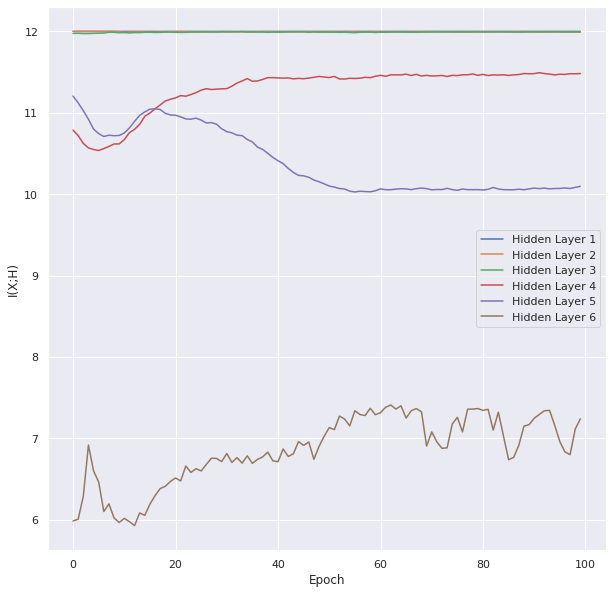

In [489]:
plot_layer_MI(np.array(MI_XH[:]), "I(X;H)")

<ipython-input-488-ff9e28970de9>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


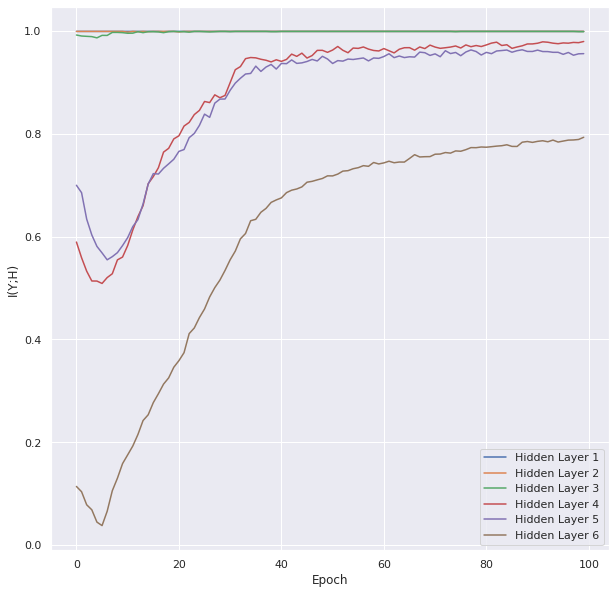

In [490]:
plot_layer_MI(np.array(MI_YH[:]), "I(Y;H)")

In [491]:
import matplotlib

100%|██████████| 100/100 [00:00<00:00, 367.48it/s]
<ipython-input-488-ff9e28970de9>:53: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


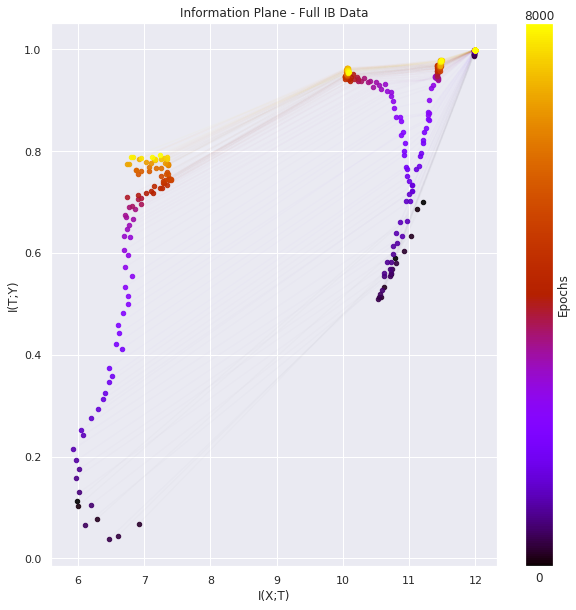

In [492]:
plot_info_plan(np.array(MI_XH[:]), np.array(MI_YH[:]))

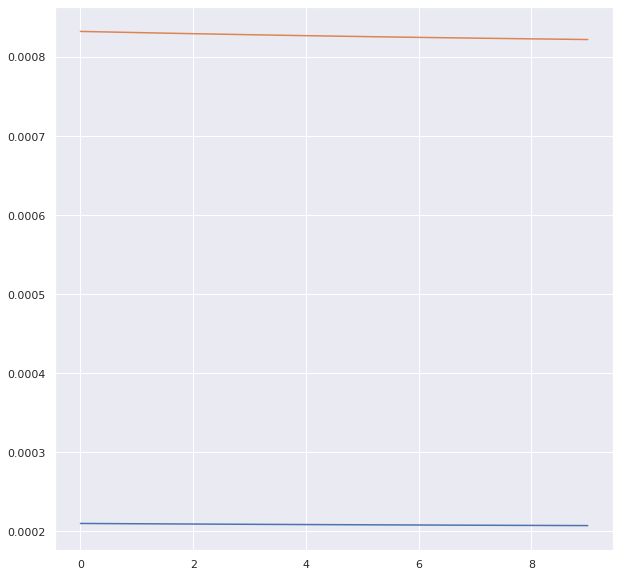

In [243]:
plt.plot(tr.train_loss)
plt.plot(tr.val_loss)

In [244]:
mutual_inf.

SyntaxError: invalid syntax (<ipython-input-244-49de674caa42>, line 1)

In [303]:
import numpy as np

def get_unique_probs(x):
    uniqueids = np.ascontiguousarray(x).view(np.dtype((np.void, x.dtype.itemsize * x.shape[1])))
    _, unique_inverse, unique_counts = np.unique(uniqueids, return_index=False, return_inverse=True, return_counts=True)
    return np.asarray(unique_counts / float(sum(unique_counts))), unique_inverse

def bin_calc_information(inputdata, layerdata, num_of_bins):
    p_xs, unique_inverse_x = get_unique_probs(inputdata)
    
    bins = np.linspace(-1, 1, num_of_bins, dtype='float32') 
    digitized = bins[np.digitize(np.squeeze(layerdata.reshape(1, -1)), bins) - 1].reshape(len(layerdata), -1)
    p_ts, _ = get_unique_probs( digitized )
    #print(p_ts)
    H_LAYER = -np.sum(p_ts * np.log2(p_ts))
    #print(H_LAYER)
    H_LAYER_GIVEN_INPUT = 0.
    print(unique_inverse_x)
    for xval in np.arange(len(p_xs)):
        p_t_given_x, _ = get_unique_probs(digitized[unique_inverse_x == xval, :])
        #print(p_t_given_x)
        H_LAYER_GIVEN_INPUT += - p_xs[xval] * np.sum(p_t_given_x * np.log2(p_t_given_x))
    #print(H_LAYER_GIVEN_INPUT)
    return H_LAYER - H_LAYER_GIVEN_INPUT

def bin_calc_information2(labelixs, layerdata, binsize):
    # This is even further simplified, where we use np.floor instead of digitize
    def get_h(d):
        digitized = np.floor(d / binsize).astype('int')
        p_ts, _ = get_unique_probs( digitized )
        return -np.sum(p_ts * np.log2(p_ts))

    H_LAYER = get_h(layerdata)
    H_LAYER_GIVEN_OUTPUT = 0
    for label, ixs in labelixs.items():
        H_LAYER_GIVEN_OUTPUT += ixs.mean() * get_h(layerdata[ixs,:])
    return H_LAYER, H_LAYER - H_LAYER_GIVEN_OUTPUT

In [304]:
from __future__ import print_function
import numpy as np

# Original MI computation code from https://github.com/ravidziv/IDNNs

def extract_probs(label, x):
    """calculate the probabilities of the given data and labels p(x), p(y) and (y|x)"""
    pys = np.sum(label, axis=0) / float(label.shape[0])
    b = np.ascontiguousarray(x).view(np.dtype((np.void, x.dtype.itemsize * x.shape[1])))
    unique_array, unique_indices, unique_inverse_x, unique_counts = \
        np.unique(b, return_index=True, return_inverse=True, return_counts=True)
    unique_a = x[unique_indices]
    b1 = np.ascontiguousarray(unique_a).view(np.dtype((np.void, unique_a.dtype.itemsize * unique_a.shape[1])))
    pxs = unique_counts / float(np.sum(unique_counts))
    p_y_given_x = []
    for i in range(0, len(unique_array)):
        indexs = unique_inverse_x == i
        py_x_current = np.mean(label[indexs, :], axis=0)
        p_y_given_x.append(py_x_current)
    p_y_given_x = np.array(p_y_given_x).T
    b_y = np.ascontiguousarray(label).view(np.dtype((np.void, label.dtype.itemsize * label.shape[1])))
    unique_array_y, unique_indices_y, unique_inverse_y, unique_counts_y = \
        np.unique(b_y, return_index=True, return_inverse=True, return_counts=True)
    pys1 = unique_counts_y / float(np.sum(unique_counts_y))
    return pys, pys1, p_y_given_x, b, unique_a, unique_inverse_x, unique_inverse_y, pxs

def calc_information_sampling(data, bins, pys1, pxs, label, b, p_YgX, unique_inverse_x,  unique_inverse_y):
    bins = bins.astype(np.float32)
    num_of_bins = bins.shape[0]
    # bins = stats.mstats.mquantiles(np.squeeze(data.reshape(1, -1)), np.linspace(0,1, num=num_of_bins))
    # hist, bin_edges = np.histogram(np.squeeze(data.reshape(1, -1)), normed=True)
    digitized = bins[np.digitize(np.squeeze(data.reshape(1, -1)), bins) - 1].reshape(len(data), -1)
    b2 = np.ascontiguousarray(digitized).view(
        np.dtype((np.void, digitized.dtype.itemsize * digitized.shape[1])))
    unique_array, unique_inverse_t, unique_counts = \
        np.unique(b2, return_index=False, return_inverse=True, return_counts=True)
    p_ts = unique_counts / float(sum(unique_counts))
    PXs, PYs = np.asarray(pxs).T, np.asarray(pys1).T
    local_IXT, local_ITY = calc_information_from_mat(PXs, PYs, p_ts, digitized, unique_inverse_x, unique_inverse_y,
                                                     unique_array)
    return local_IXT, local_ITY

def calc_condtion_entropy(px, t_data, unique_inverse_x):
    # Condition entropy of t given x
    H2X_array = np.array(list(
        calc_entropy_for_specipic_t(t_data[unique_inverse_x == i, :], px[i])
                                   for i in range(px.shape[0])))
    H2X = np.sum(H2X_array)
    return H2X


def calc_information_from_mat(px, py, ps2, data, unique_inverse_x, unique_inverse_y, unique_array):
    """Calculate the MI based on binning of the data"""
    H2 = -np.sum(ps2 * np.log2(ps2))
    H2X = calc_condtion_entropy(px, data, unique_inverse_x)
    H2Y = calc_condtion_entropy(py.T, data, unique_inverse_y)
    IY = H2 - H2Y
    IX = H2 - H2X
    return IX, IY

def calc_entropy_for_specipic_t(current_ts, px_i):
    """Calc entropy for specipic t"""
    b2 = np.ascontiguousarray(current_ts).view(
        np.dtype((np.void, current_ts.dtype.itemsize * current_ts.shape[1])))
    unique_array, unique_inverse_t, unique_counts = \
        np.unique(b2, return_index=False, return_inverse=True, return_counts=True)
    p_current_ts = unique_counts / float(sum(unique_counts))
    p_current_ts = np.asarray(p_current_ts, dtype=np.float64).T
    H2X = px_i * (-np.sum(p_current_ts * np.log2(p_current_ts)))
    return H2X

In [305]:
pys, pys1, p_YgX, b, unique_a, unique_inverse_x, unique_inverse_y, pxs = extract_probs(mutual_inf.y_onehot, mutual_inf.X)

In [306]:
test_num_of_bins = 30
bins = np.linspace(-1, 1, test_num_of_bins)

In [342]:
layer_bins = [-1.0001]

In [343]:
layer = tr.hidden_activations[0][0]

In [344]:
unique = np.unique(np.squeeze(layer.reshape(1,-1)))

In [345]:
np.setdiff1d(unique,layer_bins)

array([-0.92024475, -0.91211206, -0.91137445, ...,  0.97002053,
        0.97019756,  0.97281975], dtype=float32)

In [349]:
borders=sorted(np.setdiff1d(unique,layer_bins))

In [350]:
unique

array([-0.92024475, -0.91211206, -0.91137445, ...,  0.97002053,
        0.97019756,  0.97281975], dtype=float32)

In [351]:
borders

[-0.92024475,
 -0.91211206,
 -0.91137445,
 -0.9102076,
 -0.91008365,
 -0.90944314,
 -0.90329915,
 -0.9009801,
 -0.9001421,
 -0.89992726,
 -0.8998694,
 -0.8994344,
 -0.898428,
 -0.897979,
 -0.89734244,
 -0.89658076,
 -0.8965211,
 -0.8963967,
 -0.8963369,
 -0.8962687,
 -0.89624316,
 -0.8962089,
 -0.89522964,
 -0.8938079,
 -0.8937467,
 -0.8937215,
 -0.89366025,
 -0.8929388,
 -0.8928771,
 -0.89285433,
 -0.89280677,
 -0.892745,
 -0.89264953,
 -0.89261645,
 -0.8925545,
 -0.89234936,
 -0.8911016,
 -0.8903336,
 -0.8902686,
 -0.89020544,
 -0.8901795,
 -0.89011633,
 -0.89008987,
 -0.89007396,
 -0.8900107,
 -0.88998467,
 -0.88993865,
 -0.8899214,
 -0.8898753,
 -0.88984925,
 -0.88978595,
 -0.88903975,
 -0.8889759,
 -0.8885071,
 -0.88772196,
 -0.8872452,
 -0.88718045,
 -0.88677835,
 -0.8864176,
 -0.8863524,
 -0.8863256,
 -0.8862781,
 -0.88626033,
 -0.88621277,
 -0.88618594,
 -0.8861206,
 -0.8860768,
 -0.8860114,
 -0.8859845,
 -0.88591903,
 -0.8835006,
 -0.8834338,
 -0.8832947,
 -0.88322777,
 -0.883

In [307]:
local_IXT, local_ITY = calc_information_sampling(np.array(tr.hidden_activations[9][3]), bins, pys1, pxs, mutual_inf.y_onehot, b, p_YgX, unique_inverse_x, unique_inverse_y)

In [308]:
local_IXT, local_ITY

(8.490461701710768, 0.23215448742875466)

In [309]:
bin_calc_information2(mutual_inf.y_idx_label, tr.hidden_activations[9][3], binsize=0.07)

(8.424648725228959, 0.2266224253479603)

In [311]:
bin_calc_information(mutual_inf.X, tr.hidden_activations[0][1], test_num_of_bins)

[2455 3382 2080 ... 3358 3741 1213]


12.0

In [302]:
mutual_inf.mi_binning(mutual_inf.y_idx_label, tr.hidden_activations[0][1])


[0.00024414 0.00024414 0.00024414 ... 0.00024414 0.00024414 0.00024414] None

[0.00047214 0.00047214 0.00047214 ... 0.00047214 0.00047214 0.00047214] None
11.048486873992335

[0.00050556 0.00050556 0.00050556 ... 0.00050556 0.00050556 0.00050556] None
10.949826710759112


(12.0, 0.9991571208502705)

In [285]:
a = [0.03344727, 0.00048828, 0.07592773, 0.09521484, 0.1940918,  0.21777344,
 0.00585938, 0.01611328, 0.05102539, 0.03442383, 0.15820312, 0.11743164]
[0.03344727 0.00048828 0.07592773 0.09521484 0.1940918  0.21777344
 0.00585938 0.01611328 0.05102539 0.03442383 0.15820312 0.11743164]

In [286]:
b = [0.03344727, 0.21777344, 0.1940918,  0.11743164, 0.15820312, 0.07592773,
 0.09521484, 0.03442383, 0.05102539, 0.00585938, 0.01611328, 0.00048828]

In [287]:
sorted(a)

[0.00048828,
 0.00585938,
 0.01611328,
 0.03344727,
 0.03442383,
 0.05102539,
 0.07592773,
 0.09521484,
 0.11743164,
 0.15820312,
 0.1940918,
 0.21777344]

In [288]:
sorted(b)

[0.00048828,
 0.00585938,
 0.01611328,
 0.03344727,
 0.03442383,
 0.05102539,
 0.07592773,
 0.09521484,
 0.11743164,
 0.15820312,
 0.1940918,
 0.21777344]

In [ ]:
a

In [33]:
import multiprocessing
from joblib import Parallel, delayed

NUM_CORES = multiprocessing.cpu_count()


def calc_entropy_for_specipic_t(current_ts, px_i):
    """Calc entropy for specipic t"""
    #print(current_ts.shape)
    b2 = np.ascontiguousarray(current_ts).view(
        np.dtype((np.void, current_ts.dtype.itemsize * current_ts.shape[1])))
    unique_array, _, unique_counts = \
        np.unique(b2, return_index=False, return_inverse=True, return_counts=True)
    p_current_ts = unique_counts / float(sum(unique_counts))
    p_current_ts = np.asarray(p_current_ts, dtype=np.float64).T
    H2X = px_i * (-np.sum(p_current_ts * np.log2(p_current_ts)))
    return H2X


def calc_condtion_entropy(px, t_data, unique_inverse_x):
    # Condition entropy of t given x
    H2X_array = np.array(
        Parallel(n_jobs=NUM_CORES)(delayed(calc_entropy_for_specipic_t)(t_data[unique_inverse_x == i, :], px[i])
                                   for i in range(px.shape[0])))
    H2X = np.sum(H2X_array)
    return H2X


def calc_information_from_mat(px, py, ps2, data, unique_inverse_x, unique_inverse_y, unique_array):
    """Calculate the MI based on binning of the data"""
    H2 = -np.sum(ps2 * np.log2(ps2))
    H2X = calc_condtion_entropy(px, data, unique_inverse_x)
    H2Y = calc_condtion_entropy(py.T, data, unique_inverse_y)
    IY = H2 - H2Y
    IX = H2 - H2X
    return IX, IY


def calc_probs(t_index, unique_inverse, label, b, b1, len_unique_a):
    """Calculate the p(x|T) and p(y|T)"""
    indexs = unique_inverse == t_index
    p_y_ts = np.sum(label[indexs], axis=0) / label[indexs].shape[0]
    unique_array_internal, unique_counts_internal = \
        np.unique(b[indexs], return_index=False, return_inverse=False, return_counts=True)
    indexes_x = np.where(np.in1d(b1, b[indexs]))
    p_x_ts = np.zeros(len_unique_a)
    p_x_ts[indexes_x] = unique_counts_internal / float(sum(unique_counts_internal))
    return p_x_ts, p_y_ts

In [31]:
def calc_information_sampling(data, bins, pys1, pxs, label, b, b1, len_unique_a, p_YgX, unique_inverse_x,
                              unique_inverse_y):
    bins = bins.astype(np.float32)
    #num_of_bins = bins.shape[0]
    # bins = stats.mstats.mquantiles(np.squeeze(data.reshape(1, -1)), np.linspace(0,1, num=num_of_bins))
    # hist, bin_edges = np.histogram(np.squeeze(data.reshape(1, -1)), normed=True)
    digitized = bins[np.digitize(np.squeeze(data.reshape(1, -1)), bins) - 1].reshape(len(data), -1)
    b2 = np.ascontiguousarray(digitized).view(
        np.dtype((np.void, digitized.dtype.itemsize * digitized.shape[1])))
    unique_array, unique_inverse_t, unique_counts = \
        np.unique(b2, return_index=False, return_inverse=True, return_counts=True)
    p_ts = unique_counts / float(sum(unique_counts))
    PXs, PYs = np.asarray(pxs).T, np.asarray(pys1).T
    local_IXT, local_ITY = calc_information_from_mat(PXs, PYs, p_ts, digitized, unique_inverse_x, unique_inverse_y,unique_array)
    return local_IXT, local_ITY

In [34]:
def calc_information_for_layer_with_other(data, bins, unique_inverse_x, unique_inverse_y, label,
                                          b, b1, len_unique_a, pxs, p_YgX, pys1,layer,num_of_bins):
    local_IXT, local_ITY = calc_information_sampling(data, bins, pys1, pxs, label, b, b1,
                             len_unique_a, p_YgX, unique_inverse_x,unique_inverse_y)
    params = {}
    params['local_IXT'] = local_IXT
    params['local_ITY'] = local_ITY
    return params

In [35]:
def calc_information_for_epoch(iter_index, interval_information_display,ws_iter_index, bins, unique_inverse_x,
                               unique_inverse_y, label, b, b1,
                               len_unique_a, pys, pxs, py_x, pys1, model_path,
                               input_size, layerSize, num_of_bins,per_layer_bins=False,
                               num_of_samples=100, sigma=0.5, ss=[], ks=[]):
    """Calculate the information for all the layers for specific epoch"""
    np.random.seed(None)
    if per_layer_bins:
        params = np.array(
		[calc_information_for_layer_with_other(data=ws_iter_index[i], bins=bins[i], unique_inverse_x=unique_inverse_x,
                                unique_inverse_y=unique_inverse_y, label=label,
                                 b=b, b1=b1, len_unique_a=len_unique_a, pxs=pxs,
                                 p_YgX=py_x, pys1=pys1,layer=i,num_of_bins=num_of_bins)
            for i in range(len(ws_iter_index))])
    else:
        params = np.array(
		[calc_information_for_layer_with_other(data=ws_iter_index[i], bins=bins, unique_inverse_x=unique_inverse_x,
			                    unique_inverse_y=unique_inverse_y, label=label,
	                             b=b, b1=b1, len_unique_a=len_unique_a, pxs=pxs,
                                 p_YgX=py_x, pys1=pys1,layer=i,num_of_bins=num_of_bins)
			 for i in range(len(ws_iter_index))])
    if np.mod(iter_index, interval_information_display) == 0:
        print('Calculated The information of epoch number - {0}'.format(iter_index))
    return params


def extract_probs(label, x):
    """calculate the probabilities of the given data and labels p(x), p(y) and (y|x) """
    pys = np.sum(label, axis=0) / float(label.shape[0])
    b = np.ascontiguousarray(x).view(np.dtype((np.void, x.dtype.itemsize * x.shape[1])))
    unique_array, unique_indices, unique_inverse_x, unique_counts = \
    np.unique(b, return_index=True, return_inverse=True, return_counts=True)
    unique_a = x[unique_indices]
    b1 = np.ascontiguousarray(unique_a).view(np.dtype((np.void, unique_a.dtype.itemsize * unique_a.shape[1])))
    pxs = unique_counts / float(np.sum(unique_counts))
    p_y_given_x = []
    for i in range(0, len(unique_array)):
        indexs = unique_inverse_x == i
        py_x_current = np.mean(label[indexs, :], axis=0)
        p_y_given_x.append(py_x_current)
    p_y_given_x = np.array(p_y_given_x).T
    b_y = np.ascontiguousarray(label).view(np.dtype((np.void, label.dtype.itemsize * label.shape[1])))
    unique_array_y, unique_indices_y, unique_inverse_y, unique_counts_y = \
    np.unique(b_y, return_index=True, return_inverse=True, return_counts=True)
    pys1 = unique_counts_y / float(np.sum(unique_counts_y))
    return pys, pys1, p_y_given_x, b1, b, unique_a, unique_inverse_x, unique_inverse_y, pxs

def get_information(ws, x, label, num_of_bins, interval_information_display, \
                    model, layerSize, py_hats=0,multiple_bins=True,kde=False,
                    per_layer_bins=False, lower=False, maxentropy=True):
    """Calculate the information for the network for all the epochs and all the layers"""
    pys, pys1, p_y_given_x, b1, b, unique_a, unique_inverse_x, unique_inverse_y, pxs = extract_probs(label, x)
    np.set_printoptions(edgeitems=30)
    if per_layer_bins:
        multiple_bins=per_layer_bins
    print('Start calculating the information...')

    multiple_bins=False
    bins = np.linspace(-1, 1, num_of_bins)
    label = np.array(label).astype(np.float)
    params = np.array(Parallel(n_jobs=NUM_CORES
        )(delayed(calc_information_for_epoch)
        (i, interval_information_display, multiple_bins, ws[i], bins, unique_inverse_x, unique_inverse_y,
         label,
         b, b1, len(unique_a), pys,
         pxs, p_y_given_x, pys1, None, x.shape[1], layerSize,num_of_bins=num_of_bins)
        for i in range(len(ws))))
    return params

In [ ]:
get_information(np.array(tr.hidden_activations), mutual_inf.X, mutual_inf.y_flat, 30, 1000, None, )